In [13]:
import numpy as np
import random
import matplotlib.pyplot as plt




class material:
    def __init__(self,name:str,sigma_a:float,sigma_s:float,sigma_f:float,nu:float):
        
        self.name=name
        self.sigma_a=sigma_a
        self.sigma_s=sigma_s
        self.sigma_f=sigma_f
        self.nu=nu

        self.sigma_t=self.sigma_a+self.sigma_f+sigma_s


class source:
    def __init__(self,type:str,r:float):
        self.r=r     



def sample_initial_neutrons(number_of_neutrons,source:object):
    """ 
    will accept the number of neutrons and send their sampled x,y position. 
    
    """
    x=np.random.uniform(-source.r,source.r,size=number_of_neutrons)*np.cos(np.random.uniform(0,np.pi*2,size=number_of_neutrons))
    y=np.random.uniform(-source.r,source.r,size=number_of_neutrons)*np.sin(np.random.uniform(0,np.pi*2,size=number_of_neutrons))

    return x,y 






In [14]:


X_left=0
X_right=10

Y_up=10
Y_down=0

Nx=100
Ny=Nx

dx=(X_right-X_left)/Nx
dy=(Y_up-Y_down)/Ny

X = np.linspace(dx*0.5, (X_right-X_left) - 0.5*dx,Nx)
Y = np.linspace(dx*0.5, (Y_up-Y_down) - 0.5*dx,Ny)

X,Y=np.meshgrid(X,Y)

In [15]:
uo2=material(name='fuel',sigma_a=0.2,sigma_f=.3,sigma_s=3,nu=2.5)
h20=material(name='coolant',sigma_a=.5,sigma_f=0,sigma_s=0.7,nu=0)

source=source(type='neutron',r=2)

fuel_rad=6

def find_mat(pos):

    x=pos[0]
    y=pos[1]
    
    if x**2+y**2<=fuel_rad:
        return uo2
    elif(x**2+y**2>fuel_rad) and abs(x)<=X_right and abs (y)<=Y_up :
        return h20
    else:
        return None
    
def find_surface_intersection_point(pos,pos_new):

    a=pos[0]
    b=pos[1]
    a_new=pos_new[0]
    b_new=pos_new[1]

    tol=1e-7

    for i in range (100):
        x=(a+a_new)/2
        y=(b+b_new)/2

        if abs(x**2+y**2-fuel_rad)<tol:
            break
        elif (x**2+y**2-fuel_rad)>0:
            a_new=x
            b_new=y
        elif (x**2+y**2-fuel_rad)<0:
            a=x
            b=y
    return x,y

In [16]:
active_batch=100
inactive_batch=50
no_of_gen_per_batch=1
number_of_neutrons=1000
N=number_of_neutrons

total_batch=active_batch+inactive_batch

scalar_flux = np.zeros((Nx,Ny))
scalar_flux_tl = np.zeros_like (scalar_flux)
weights=np.ones(number_of_neutrons)

In [17]:

x,y=sample_initial_neutrons(number_of_neutrons=number_of_neutrons,source=source)

(-10.0, 10.0)

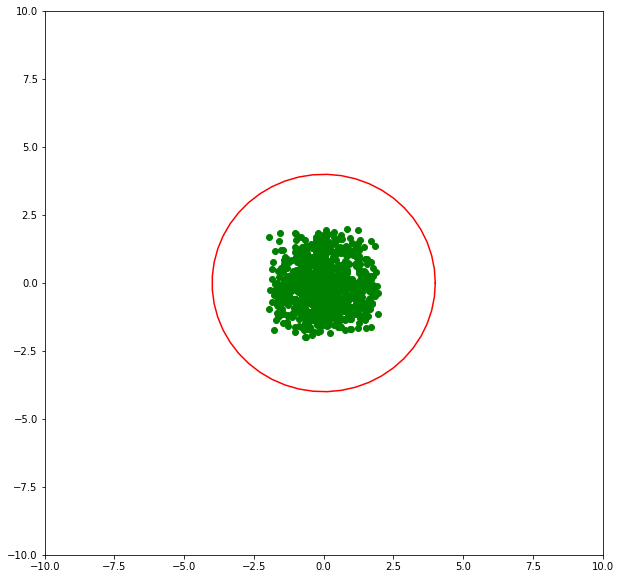

In [18]:
plt.figure(figsize=(10,10))
plt.scatter(x,y,color='g')
plt.plot(4*np.cos(np.linspace(0,np.pi*2)),4*np.sin(np.linspace(0,np.pi*2)),color='red')
plt.xlim(-10,10)
plt.ylim(-10,10)

In [19]:

fission_sites_x=np.array([])
fission_sites_y=np.array([])

k=np.zeros(active_batch+inactive_batch)



In [20]:
for batch in range (active_batch+inactive_batch):
    
    number_of_neutrons=N
    weights=np.ones(number_of_neutrons)
    scalar_flux = np.zeros((Nx,Ny))


    for g in range(no_of_gen_per_batch):
        
        weights_old=weights.copy()
        next_gen_neutron=0

        for n in range(number_of_neutrons):

            mu=np.random.rand()*2-1
            eta=np.sqrt(1-mu**2)
            initail_dir=np.array([mu,eta])

            weight=weights[n]
            
            alive=True
            pos=np.array([x[n],y[n]])


            
            while alive: 

                ''' sample distance first'''
                material=find_mat(pos)
                rand_num=np.random.rand()               
                l=-np.log(rand_num)/material.sigma_t

                """ check it the from that position the particle will cross any boundray?"""
                if find_mat(pos)!=find_mat(pos+l*initail_dir):

                    '''calculating the boundary crossing position'''
                    x_,y_=find_surface_intersection_point(pos=pos,pos_new=(pos+l*initail_dir))
                    l=np.sqrt((x_-pos[0])**2+(y_-pos[1])**2)
                    
                
                #sample the angualar direction as well
                

                if find_mat(pos)==None: 
                    alive=False
                else: 
                    '''
                      now we sample the direction 
                    '''
                    reaction_type=np.random.choice(['scattering','capture','fission'],p=[material.sigma_s/material.sigma_t,material.sigma_a/material.sigma_t,material.sigma_f/material.sigma_t])
                    if reaction_type=='scattering':
                        '''
                            change particle direction by sampling new mu and eta for new direction 
                        '''
                        mu=np.random.rand()*2-1
                        eta=np.sqrt(1-mu**2)
                        
                        if np.random.rand()<=0.5:
                            eta=-eta
                        pos=pos+l*initail_dir
                        initail_dir=np.array([mu,eta])
                        
                        weight=weight*material.sigma_s
                        x_cell_index=int(pos[0]/dx)
                        y_cell_index=int(pos[1]/dy)

                        scalar_flux[x_cell_index][y_cell_index]=scalar_flux[x_cell_index][y_cell_index]+weight*l

                    elif reaction_type=='capture':
                        ''' 
                            kill the particle
                        '''
                        weight=weight*material.sigma_a

                        x_cell_index=int(pos[0]/dx)
                        y_cell_index=int(pos[1]/dy)

                        scalar_flux[x_cell_index][y_cell_index]=scalar_flux[x_cell_index][y_cell_index]+weight*l

                        alive=False
                        
                    else: 
                        ''' as there are only three choice the other one will be fission 

                            1. adjust particle weight and kill the particle
                            2. keep the record of the fissoion sites 
                            3. keep the record of the fission site's weights 

                        '''

                        
                        rand_num=np.random.rand()

                        if rand_num>(material.nu-int(material.nu)):
                            new_neutrons=int(material.nu)+1
                        else:
                            new_neutrons=int(material.nu)
                        
                        x_cell_index=int(pos[0]/dx)
                        y_cell_index=int(pos[1]/dy)
                        next_gen_neutron=next_gen_neutron+new_neutrons

                        scalar_flux[x_cell_index][y_cell_index]=scalar_flux[x_cell_index][y_cell_index]+weight*l
                        
                        for i in range (new_neutrons):
                            fission_sites_y=np.append(fission_sites_y,pos[1])
                            fission_sites_x=np.append(fission_sites_x,pos[0])

    
        
        for i in range(number_of_neutrons): 
            x[i]=random.choice(fission_sites_x)
            y[i]=random.choice(fission_sites_y)

        fission_sites_x=np.array([])
        fission_sites_y=np.array([])
    
    k[batch]=(next_gen_neutron/number_of_neutrons)
    if batch> inactive_batch:
        print('%.6f' % (next_gen_neutron/number_of_neutrons), ' ','%.6f' % np.mean(k[inactive_batch:batch]),"+/-",'%.6f' % np.var(k[inactive_batch:batch]))
    else:
        print('%.6f' % (next_gen_neutron/number_of_neutrons))
    number_of_neutrons=next_gen_neutron


3.293000
2.950000
2.698000
2.708000
2.668000
2.728000
2.818000
2.723000
2.586000
2.880000
2.756000
2.820000
2.785000
2.908000
2.783000
2.656000
2.813000
2.915000
2.421000
2.562000
2.697000
2.817000
2.759000
2.569000
2.780000
2.793000
2.640000
2.615000
2.697000
2.567000
2.694000
2.731000
2.629000
2.669000
2.650000
2.780000
2.764000
2.748000
2.850000
2.834000
2.636000
2.720000
2.619000
2.536000
2.747000
2.813000
2.861000
2.723000
2.666000
2.553000
2.590000
2.671000   2.590000 +/- 0.000000
2.806000   2.630500 +/- 0.001640
2.719000   2.689000 +/- 0.007938
2.989000   2.696500 +/- 0.006122
2.718000   2.755000 +/- 0.018587
2.704000   2.748833 +/- 0.015679
2.695000   2.742429 +/- 0.013685
2.902000   2.736500 +/- 0.012221
2.846000   2.754889 +/- 0.013568
2.693000   2.764000 +/- 0.012958
2.915000   2.757545 +/- 0.012197
2.999000   2.770667 +/- 0.013074
2.920000   2.788231 +/- 0.015771
2.659000   2.797643 +/- 0.015796
2.789000   2.788400 +/- 0.015939
3.016000   2.788438 +/- 0.014943
2.873000   2.

In [ ]:
print(np.mean(k[inactive_batch:]),"+/-",np.var(k[inactive_batch:]))

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(scalar_flux)

In [ ]:
scalar_flux

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(fission_sites_x,fission_sites_y)